# L4b: One versus the Rest Strategy for Multi-class Classification
In this lab, we will implement the One versus the Rest (OvR) strategy for multi-class classification using logistic regression. The OvR strategy involves training a separate binary classifier for each class, where each classifier distinguishes one class from the rest of the classes. 

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> 
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
First, we define some constants that will be used throughout the lab. See the comments for explanations of each constant.

In [2]:
number_of_examples = 3000; # how many training examples of *each* number to include from the library
number_of_test_examples = 500; # how many examples are we going to test on?
number_of_training_examples = number_of_examples - number_of_test_examples; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

### Data
Our data consists of images of handwritten digits (0–9) from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). 

First, we build a training dataset of images to estimate the model parameters, stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable. Next, we construct a test dataset to evaluate how well the FNN generalizes to data it has never seen, stored in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

> __Data format:__ The first element of each tuple is the input data $\mathbf{x}$ (the image pixels arranged as a vector), and the second element is the label (whether the image corresponds to digits 0–9).
>
> __Type considerations:__ The floating-point precision is `Float32` rather than the default `Float64` to reduce memory usage. The labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot), and the input data is stored as a vector rather than a matrix (even though the original image is a $28\times 28$ matrix of grayscale values).

We load `number_of_training_examples::Int` images into the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` and then later convert these to vector format by linearizing the $28\times 28$ matrix of grayscale values into a vector of 784 pixels.

In [3]:
digits_image_dictionary = MyMNISTHandwrittenDigitImageDataset(number_of_examples = number_of_examples);

What's in the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` variable?

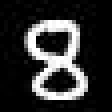

In [4]:
digits_image_dictionary[8][ :, :, 10] # how does the indexing work? This is the 10th example of the digit "8"

Next, let's partition the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` into training and testing datasets. We randomly select `number_of_training_examples::Int` images per digit for training, and the remaining images are used for testing. In each case, we convert the $28\times 28$ images into vector format by linearizing the matrix into a vector of 784 pixels.

Let's start with the training dataset. 

> __What is vectorization?__ Each $N\times N$ image array containing grayscale values at each pixel is converted to an $N^{2}$ vector by concatenating pixel values. The image class (the digit it represents) is converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). 

Let's save the training data in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.

In [7]:
training_image_dataset = let

    # initialize -
    training_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}();
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"

        for t ∈ 1:number_of_training_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            training_tuple = (D,Y); # create training tuple (image data, image class)
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset; # return
end

25000-element Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03137254901960784, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01568627450980392  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 

Next, we load `number_of_test_examples::Int` images from the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` for testing purposes. We save the test data in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

In [8]:
testing_image_dataset = let
    
    # initialize -
    testing_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}()
    
    # main -
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"
        
        for t ∈ (number_of_training_examples+1):number_of_examples

            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            testing_tuple = (D,Y); # create testing tuple (image data, image class)
            push!(testing_image_dataset, testing_tuple);
        end
    end

    testing_image_dataset; # return
end;

## Task 1: Create the One versus the Rest (OvR) Dataset
In this task, we will create the dataset for the One versus the Rest (OvR) strategy. This involves creating separate binary classification datasets for each class (digit) in our multi-class classification problem.

## Summary 
One direct summary sentence goes here.

> __Key Takeaways:__
>
> Three key takeaways go here.

One direct concluding sentence goes here.
___